In [2]:
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

In [ ]:
straight_1 = [(28.602109, -81.196847), (28.602090954218884, -81.196847)]
turn_1 = [(28.602090954218884, -81.196847), (28.602001, -81.196720)] # left
straight_2 = [(28.602001, -81.196720), (28.60200099999653, -81.19668932823143)]
turn_2 = [(28.60200099999653, -81.19668932823143), (28.602090, -81.196589)] # left
straight_3 = [(28.602090, -81.196589), (28.602117068671642, -81.196589)]
turn_3 = [(28.602117068671642, -81.196589), (28.602195, -81.196702)] # left
straight_4 = [(28.602195, -81.196702), (28.602194999996524, -81.1967326718249)]
turn_4 = [(28.602194999996524, -81.1967326718249), (28.602109, -81.196847)] # left

# all speeds 0.2 m/s

center_lat, center_lon = 28.602099500061353, -81.19671799998841

In [ ]:
bearing, _, dist = geodesic.inv(-81.196847, 28.602109, -81.196589, 28.602090)

center_lon, center_lat, _ = geodesic.fwd(-81.196847, 28.602109, bearing, dist/2)

print(center_lat, center_lon)

In [7]:
import json
import math
import numpy as np

EARTH_RADIUS = 6371e3
DUE_EAST = 90

with open("/Users/owenburns/workareas/cavrel-platooning/missions/tracks/garage_loop.json", 'r') as f:
    track = json.load(f)

def coords_to_local(target_lat, target_lon):
    """Converts GPS coordinates to local cartesian coordinates with respect to the track center point."""

    target_lat_rad, target_lon_rad = math.radians(target_lat), math.radians(target_lon)
    current_lat_rad, current_lon_rad = math.radians(track['center']['lat']), math.radians(track['center']['lon'])

    x = EARTH_RADIUS * (target_lon_rad - current_lon_rad) * math.cos((current_lat_rad + target_lat_rad) / 2)
    y = EARTH_RADIUS * (target_lat_rad - current_lat_rad)

    angle = math.radians(DUE_EAST - DUE_EAST)
    qx = math.cos(angle) * x - math.sin(angle) * y
    qy = math.sin(angle) * x + math.cos(angle) * y
    return qx, qy

def calculate_straight(start, end, seg_dist):
    bearing, _, dist = geodesic.inv(start[1], start[0], end[1], end[0])
    seg_count = int(dist/seg_dist)
    segs = [(start[0], start[1], bearing)]
    for _ in range(seg_count):
        lat_prev, lon_prev, _ = segs[-1]
        lon_next, lat_next, _ = geodesic.fwd(lon_prev, lat_prev, bearing, seg_dist)
        segs.append((lat_next, lon_next, bearing))

    return segs, bearing

def calculate_turn(start, start_bearing, end, end_bearing, seg_dist, direction='left'):
    """Treats the start and end as vertices of the ellipse along its major and minor axes, and calculates the curge
    between them. The curve is calculated by incrementing the angle along the ellipse and calculating the distance.
    This method only works for turns up to 90 degrees."""

    bearing, _, dist = geodesic.inv(start[1], start[0], end[1], end[0])

    # determine starting angle along ellipse
    # compass angle being in degrees, and ellipse in radians
    if direction == 'left':
        c2e = lambda c_bearing: np.deg2rad((360 - c_bearing) % 360)
        e2c = lambda e_angle: (360 - np.rad2deg(e_angle)) % 360
        anglediff = lambda angle_1, angle_2: (angle_2 - angle_1 + np.pi*2) % (np.pi*2)
        increment = 0.001
    else:
        # TODO: implement support for right turns
        raise NotImplementedError("Right turns aren't supported yet")
    
    bearing = c2e(bearing)
    x_mult = abs(np.cos(bearing)*dist)
    y_mult = abs(np.sin(bearing)*dist)

    t_start = c2e(start_bearing)
    t_end = c2e(end_bearing)
    turn = anglediff(t_start, t_end)
    progress = 0

    # print(f"start_bearing: {start_bearing}, end_bearing: {end_bearing}")
    # print(f"t_start: {np.rad2deg(t_start)}, t_end: {np.rad2deg(t_end)}")

    points = [(x_mult*np.sin(t_start), y_mult*np.cos(t_start))]
    full_track = [(*start, start_bearing)]
    t = t_start

    while progress < turn:
        t = (t + increment) % (np.pi*2)
        progress += increment

        x = x_mult*np.sin(t)
        y = y_mult*np.cos(t)

        lx, ly = points[-1]
        dist = np.sqrt((x - lx)**2 + (y - ly)**2)
        if dist >= seg_dist:
            points.append((x, y))

            bearing = np.rad2deg(np.arctan2(y - ly, x - lx))
            lon_next, lat_next, _ = geodesic.fwd(full_track[-1][1], full_track[-1][0], bearing, dist)
            full_track.append((lat_next, lon_next, e2c(t)))

    final_point = (x_mult*np.sin(t_end), y_mult*np.cos(t_end))
    if points[-1] != final_point:
        dist = np.sqrt((final_point[0] - points[-1][0])**2 + (final_point[1] - points[-1][1])**2)
        bearing = np.rad2deg(np.arctan2(final_point[1] - points[-1][1], final_point[0] - points[-1][0]))
        lon_next, lat_next, _ = geodesic.fwd(full_track[-1][1], full_track[-1][0], bearing, dist)
        full_track.append((lat_next, lon_next, e2c(t_end)))

    return full_track

def calculate_track(straights, turns, broadcast_interval):
    straight_points = []
    bearings = []
    for straight in straights:
        seg_dist = broadcast_interval*straight['speed']
        start = (straight['start']['lat'], straight['start']['lon'])
        end = (straight['end']['lat'], straight['end']['lon'])
        segs, bearing = calculate_straight(start, end, seg_dist)
        straight_points.append(segs)
        bearings.append(bearing)

    bearings = [(bearings[i], bearings[(i+1)%len(bearings)]) for i in range(len(bearings))]
    turn_points = []
    for turn, (start_bearing, end_bearing) in zip(turns, bearings):
        seg_dist = broadcast_interval*turn['speed']
        start = (turn['start']['lat'], turn['start']['lon'])
        end = (turn['end']['lat'], turn['end']['lon'])
        segs = calculate_turn(start, start_bearing, end, end_bearing, seg_dist, turn['direction'])
        turn_points.append(segs)

    print(turn_points[1])

    full_track = []
    for straight, turn in zip(straight_points, turn_points):
        full_track += straight + turn

    return full_track

full_track = calculate_track(track['straights'], track['turns'], 0.1)

[(28.601863, -81.195277, 89.99997630333992), (28.601863049360958, -81.19527493266823, 87.47896200476345), (28.601863197346454, -81.1952728693382, 84.95794770618699), (28.601863443670034, -81.19527081400388, 82.43693340761052), (28.601863787854892, -81.19526877064374, 79.91591910903401), (28.601864229234806, -81.1952667432131, 77.39490481045755), (28.601864753671844, -81.19526478101415, 74.93118629139423), (28.601865369151326, -81.19526284140464, 72.46746777233085), (28.6018660745354, -81.19526092797037, 70.00374925326747), (28.601866868520023, -81.19525904424873, 67.5400307342041), (28.601867728168518, -81.19525723635493, 65.13360799465386), (28.60186866942855, -81.19525546331911, 62.72718525510362), (28.60186969063997, -81.19525372826843, 60.32076251555333), (28.601870762932716, -81.1952520740965, 57.97163555551617), (28.601871907896804, -81.19525046181917, 55.62250859547902), (28.601873123607817, -81.19524889414629, 53.273381635441865), (28.60187437589453, -81.19524741021426, 50.9815

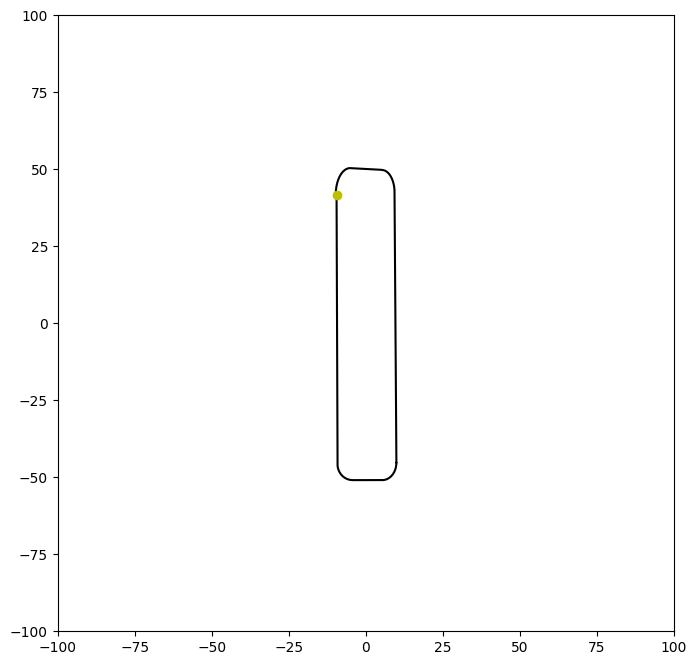

In [8]:
from typing import List
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib.text import Annotation
from matplotlib.lines import Line2D
from IPython.display import HTML
import matplotlib
import math
matplotlib.rcParams['animation.embed_limit'] = 2**128
EARTH_RADIUS = 6371e3
DUE_EAST = 90

center_latitude = track['center']['lat']
center_longitude = track['center']['lon']
center_orientation = DUE_EAST

def coords_to_local(target_lat, target_lon):
    # Convert lat, lon to radians
    target_lat_rad, target_lon_rad = math.radians(target_lat), math.radians(target_lon)
    current_lat_rad, current_lon_rad = math.radians(center_latitude), math.radians(center_longitude)

    x = EARTH_RADIUS * (target_lon_rad - current_lon_rad) * math.cos((current_lat_rad + target_lat_rad) / 2)
    y = EARTH_RADIUS * (target_lat_rad - current_lat_rad)

    angle = math.radians(center_orientation - DUE_EAST)
    qx = math.cos(angle) * x - math.sin(angle) * y
    qy = math.sin(angle) * x + math.cos(angle) * y
    return qx, qy

xy_points = [coords_to_local(lat, lon) for lat, lon, heading in full_track]
xs = [point[0] for point in xy_points]
ys = [point[1] for point in xy_points]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(autoscale_on=False, xlim=(-100, 100), ylim=(-100, 100))
ax.plot(xs, ys, 'k-', label='Track Path')  # green dots connected by lines
ax.plot(xs[0], ys[0], 'yo', label='Start/End Point')
ax.set_aspect('equal')

# pt = Line2D([xs[0]], [ys[0]], marker='o', color='green')

# def init_func() -> list:
#     print('init_func')
#     ax.add_artist(pt)
#     return []

# def func(frame, *fargs) -> list:
#     global pt

#     pt.set_data([xs[frame]], [ys[frame]])

#     return []

# ax.set_xlabel('Meters East of Center')
# ax.set_ylabel('Meters North of Center')
# ax.set_title('Vehicle Path and Vectors')
# ax.legend()
# ax.grid()

# # Create animation
# ani = FuncAnimation(fig, func, range(len(xy_points)), init_func, blit=True, interval=50) # Adjust interval as needed
# HTML(ani.to_jshtml())